In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

plt.style.use('ggplot')

import nltk
import json 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishikesanravichandran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rishikesanravichandran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishikesanravichandran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Read the sample json 
data = json.load(open('../scraping/test_reddit_sample.json'))

In [19]:
def transform_data(teams):
    '''
    This function will transform the raw data into a dataframe, where every row will be a sentence from the comments'''
    #Structure the raw data into a dataframe, every sentence will be a row in the dataframe
    row=[]
    for title, value in data.items():
        title=title
        description = value['description']
        comments = value['comments']

        messages=[title,description]+comments

        for message in messages:
            message=message.lower()

            #Check if the message contains any of the teams
            if teams[0] in message and teams[1] not in message:
                row.append({"team":teams[0],"message":message})
            elif teams[1] in message and teams[0] not in message:
                row.append({"team":teams[1],"message":message})
            '''
            For now, we are not considering the messages that contain both teams.
            However, we will have to consider them in the future, as they might contain useful information. 
            '''

    #Now create the dataframe
    return pd.DataFrame(row)

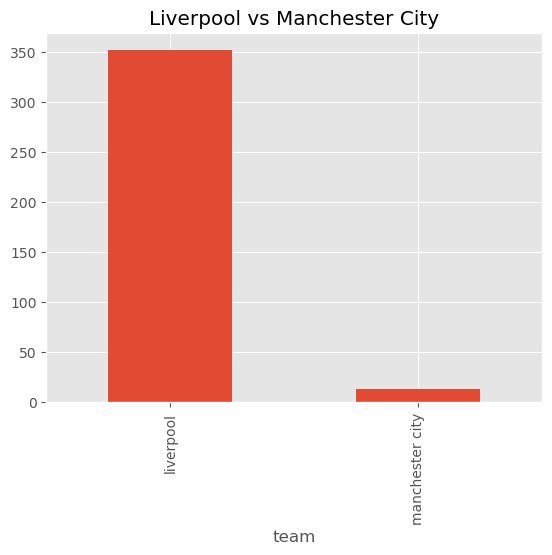

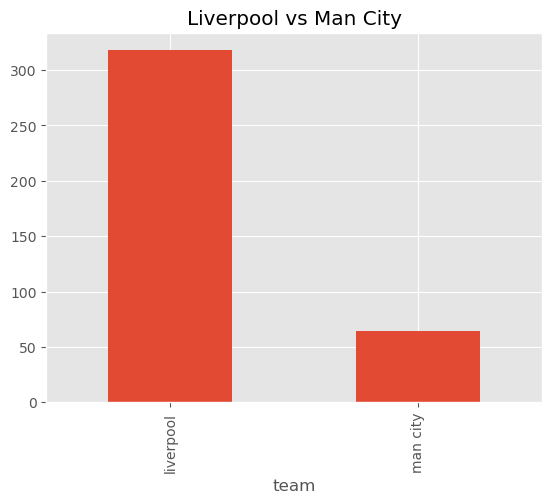

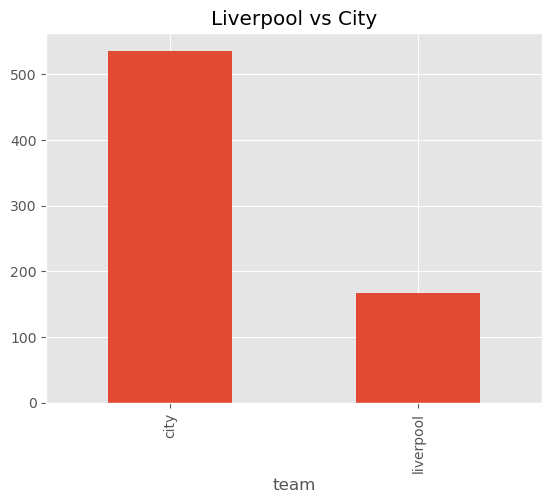

In [30]:
# Sample match tag for our analysis.
matches = ["Liverpool vs Manchester City", "Liverpool vs Man City", "Liverpool vs City"]

for match in matches:
    teams = [team.lower() for team in match.split(' vs ')]
    df = transform_data(teams)
    df['team'].value_counts().plot(kind='bar',title=match)
    plt.show()

In [31]:
'''
The above data run for the sample json file is dated 2024-03-09.

The google prediction for the match "Liverpool vs Manchester City" 
on 2024-03-10 is 33% for Liverpool, 42% for Manchester City and 25% for a draw
as of 2024-03-09.
'''

'\nThe above data run for the sample json file is dated 2024-03-09.\n\nThe google prediction for the match "Liverpool vs Manchester City" \non 2024-03-10 is 33% for Liverpool, 42% for Manchester City and 25% for a draw\nas of 2024-03-09.\n'

In [4]:
# Data Preprocessing 

#We'll use lemmatizer to get the basic form of a word without tense 
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #First we'll lowercase the text
    text = text.lower()
    
    #Now remove the punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #We'll now tokenize the text to words
    words = word_tokenize(text)
    
    #Now remove stopwards, and lemmatize them
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')] 
    return ' '.join(words)



In [6]:
# Data Exploration 
def exploration(data_fans):
    #We'll use Vectorizer takes the row text and count them and put into a matrix
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data_fans['message'])

    #Count the occurence of each word 
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()

    #Now get the top 30 words
    top_30_words = word_freq.nlargest(30)

    #Display the top 30 words
    top_30_words.plot(kind='bar')
    plt.title(f"Top words in Reddit during {match}")
    plt.show()

In [ ]:
# Model Building 
# Model 1 - Bag of Words 

def model_1(data_fans):

    # Define your sentiment scores
    sentiment_scores = {'money':1,'trade':-1,'minor':-1,'contract':-1,'deal':1,'last':-1,'strength':1,'win':1,'lose':-1}

    # Create a new CountVectorizer, only considering the words in sentiment_scores
    vectorizer_sentiment_scores = CountVectorizer(vocabulary=sentiment_scores.keys())
    X_sentiment_scores = vectorizer_sentiment_scores.fit_transform(data_fans['message'])

    # Convert this matrix into a DataFrame
    df_sentiment_scores = pd.DataFrame(X_sentiment_scores.toarray(), columns=vectorizer_sentiment_scores.get_feature_names_out())

    # Multiply each column by its corresponding sentiment score
    for word, score in sentiment_scores.items():
        df_sentiment_scores[word] *= score

    # Concatenate with the original DataFrame
    data_fans = pd.concat([data_fans, df_sentiment_scores], axis=1)

    data_fans['sentiment_score'] = data_fans.iloc[:,2:].sum(axis=1)
    data_fans['sentiment_label']= data_fans['sentiment_score'].apply(lambda x: "positive" if x>0 else ("negative" if x < 0 else "neutral"))

    # Group by 'team' and compute sentiment counts
    sentiment_counts = data_fans.groupby('team')['sentiment_label'].value_counts().unstack().fillna(0)

    # Compute sentiment percentages
    sentiment_counts['total'] = sentiment_counts.sum(axis=1)
    sentiment_counts['%positive'] = sentiment_counts['positive'] / sentiment_counts['total'] * 100
    sentiment_counts['%negative'] = sentiment_counts['negative'] / sentiment_counts['total'] * 100
    sentiment_counts['%neutral'] = sentiment_counts['neutral'] / sentiment_counts['total'] * 100

    # Compute win percentage
    sentiment_counts['win_percentage'] = sentiment_counts['%positive'] / sentiment_counts['total'] * 100

    # Normalize win percentages so they add up to 100%
    total_win_percentage = sentiment_counts['win_percentage'].sum()
    sentiment_counts['normalized_win_percentage'] = sentiment_counts['win_percentage'] / total_win_percentage * 100

    return sentiment_counts

